In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pandas_datareader import data as pdr
import yfinance as yf
import cvxopt as opt
from cvxopt import blas, solvers
from dateutil.relativedelta import relativedelta
from datetime import datetime

In [28]:
start_investment = int(input('Enter Starting Investment:')) 
final_return = int(input('Enter desired final return:'))  
timeline_years = int(input('Enter timeline to achieve the final return:'))  
risk_tolerance = int(input('Enter Risk tolerance in %:'))/100

In [29]:
tickers = input("Enter the stock ticker symbols separated by commas: ").split(',')
tickers = [ticker.strip().upper() for ticker in tickers]

In [30]:
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = datetime.now() - relativedelta(years=timeline_years)
start_date = start_date.strftime('%Y-%m-%d')
stock_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
returns = stock_data.pct_change().dropna()

[*********************100%%**********************]  10 of 10 completed


In [31]:
def monte_carlo_simulation(returns, num_simulations=10000):
    num_assets = len(returns.columns)
    results = np.zeros((3, num_simulations))  # 3 rows for return, risk, Sharpe ratio
    weights_record = []  # Create a separate list to store the weights

    for i in range(num_simulations):
        # Random portfolio weights
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)

        # Portfolio performance
        portfolio_return = np.sum(returns.mean() * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
        
        # Store results
        results[0, i] = portfolio_return
        results[1, i] = portfolio_std_dev
        results[2, i] = results[0, i] / results[1, i]  # Sharpe Ratio

        # Store the weights
        weights_record.append(weights)

    return results, weights_record

# Run the Monte Carlo simulation
results, weights_record = monte_carlo_simulation(returns)

In [32]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_ratio = results[:, max_sharpe_idx]
optimal_weights = weights_record[max_sharpe_idx]

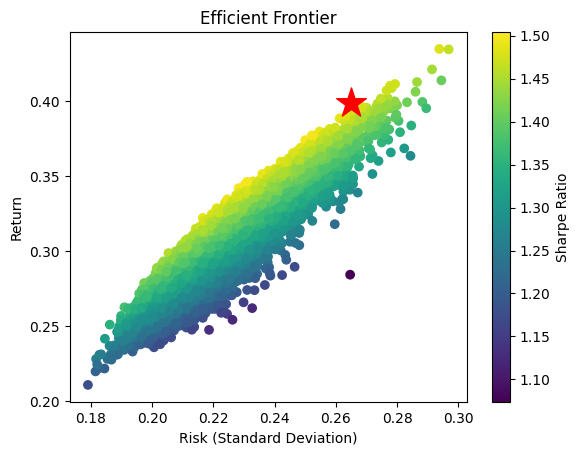

In [33]:
plt.scatter(results[1,:], results[0,:], c=results[0,:]/results[1,:], marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe_ratio[1], max_sharpe_ratio[0], marker='*', color='r', s=500)  # Mark the max Sharpe ratio
plt.show()

In [34]:
def black_litterman(returns, tau=0.025):
    pi = np.dot(returns.mean(), returns.cov())
    omega = np.dot(np.dot(np.eye(len(tickers)), returns.cov()), np.eye(len(tickers)).T)
    posterior_mean = np.dot(np.linalg.inv(np.linalg.inv(tau * returns.cov()) + np.linalg.inv(omega)), 
                            np.dot(np.linalg.inv(tau * returns.cov()), pi) + np.dot(np.linalg.inv(omega), pi))
    return posterior_mean

bl_mean = black_litterman(returns)

In [35]:
def portfolio_optimization(returns, bl_mean, risk_tolerance, timeline_years, final_return):
    num_assets = len(tickers)
    args = (returns.mean(), returns.cov())
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'ineq', 'fun': lambda x: final_return - np.sum(x * bl_mean) * 252 * timeline_years})
    
    bounds = tuple((0, 1) for asset in range(num_assets))
    
    result = minimize(lambda x: -np.sum(x * bl_mean) / (np.sqrt(np.dot(x.T, np.dot(returns.cov() * 252, x))) * risk_tolerance),
                      num_assets * [1./num_assets,],
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)
    
    return result

In [36]:
optimized_portfolio = portfolio_optimization(returns, bl_mean, risk_tolerance, timeline_years, final_return)
print("Optimized Portfolio Weights: ", optimized_portfolio.x)
print("Expected Return: ", np.sum(optimized_portfolio.x * returns.mean()) * 252)
print("Expected Risk: ", np.sqrt(np.dot(optimized_portfolio.x.T, np.dot(returns.cov() * 252, optimized_portfolio.x))))
print("Max Sharpe Ratio Portfolio Weights from Monte Carlo Simulation: ", optimal_weights)
print("Max Sharpe Ratio: ", max_sharpe_ratio[2])

Optimized Portfolio Weights:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Expected Return:  0.3103969502936323
Expected Risk:  0.22145736793979265
Max Sharpe Ratio Portfolio Weights from Monte Carlo Simulation:  [0.03123428 0.03892785 0.04198379 0.09489674 0.12453452 0.01742908
 0.10678927 0.28123469 0.19117312 0.07179666]
Max Sharpe Ratio:  1.5042501923362561
